In [ ]:
#import des dépendances
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import ruptures as rpt
plt.style.use("seaborn-v0_8")

In [ ]:

# 2) Chargement et prétraitement
df_weekly = pd.read_csv('Steam_users_10min_last_week.csv', sep=';', encoding='utf-8')

# Convertir DateTime en datetime
df_weekly['DateTime'] = pd.to_datetime(df_weekly['DateTime'])

# Trier par date (important)
df_weekly = df_weekly.sort_values('DateTime')

# DateTime comme index
df_weekly = df_weekly.set_index('DateTime')

# Convertir Users en numérique (enlevant les virgules si nécessaire)
df_weekly['Users'] = df_weekly['Users'].astype(str).str.replace(",", "").astype(float)

df_weekly.head()


,Users,Average Users,In-Game
DateTime,,,
2004-01-13,84998.0,NaN,NaN
2004-01-14,NaN,NaN,NaN
2004-01-15,NaN,NaN,NaN
2004-01-16,NaN,NaN,NaN
2004-01-17,NaN,NaN,NaN


In [ ]:
print(df_weekly.info())
print(df_weekly.describe())

# Vérification des valeurs manquantes
print(df_weekly.isna().mean()*100)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9498 entries, 2004-01-13 00:00:00 to 2025-10-21 14:10:00
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Users          8288 non-null   float64
 1   Average Users  1830 non-null   float64
 2   In-Game        4443 non-null   float64
dtypes: float64(3)
memory usage: 296.8 KB
None
              Users  Average Users       In-Game
count  8.288000e+03   1.830000e+03  4.443000e+03
mean   1.669529e+07   2.733877e+07  7.474801e+06
std    1.195705e+07   3.027405e+06  2.198252e+06
min    8.499800e+04   1.989707e+07  2.492645e+06
25%    5.012519e+06   2.497485e+07  5.800756e+06
50%    1.480899e+07   2.820251e+07  7.180171e+06
75%    2.685502e+07   2.922399e+07  9.248002e+06
max    4.166646e+07   3.261549e+07  1.319469e+07
Users            12.739524
Average Users    80.732786
In-Game          53.221731
dtype: float64


In [7]:
# Lissage des valeurs manquantes   

df_weekly['Users'] = df_weekly['Users'].interpolate(method='time')

df_weekly['In-Game'] = df_weekly['In-Game'].interpolate(method='time')

# On ignore Average Users pour la suite car on ne peux pas l'utiliser comme feature (80% de valeurs manquantes)
df_weekly = df_weekly.drop(columns=['Average Users'])


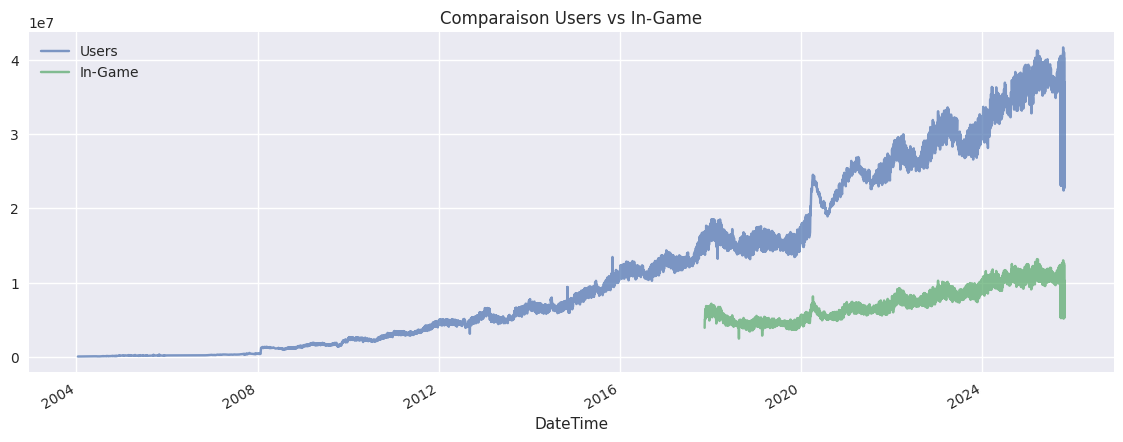

,Users,In-Game
Users,1.000000,0.958132
In-Game,0.958132,1.000000


In [ ]:
# Vérification de la correlation entre users et in-game pour voir si on peut utiliser les deux features

df_weekly[['Users', 'In-Game']].plot(figsize=(14,5), alpha=0.7)
plt.title("Comparaison Users vs In-Game")
plt.show()

df_weekly[['Users', 'In-Game']].corr()


Bon point : les deux feature sont fortement corrélées (0.958), on pourra donc utiliser in game pour les prédictions

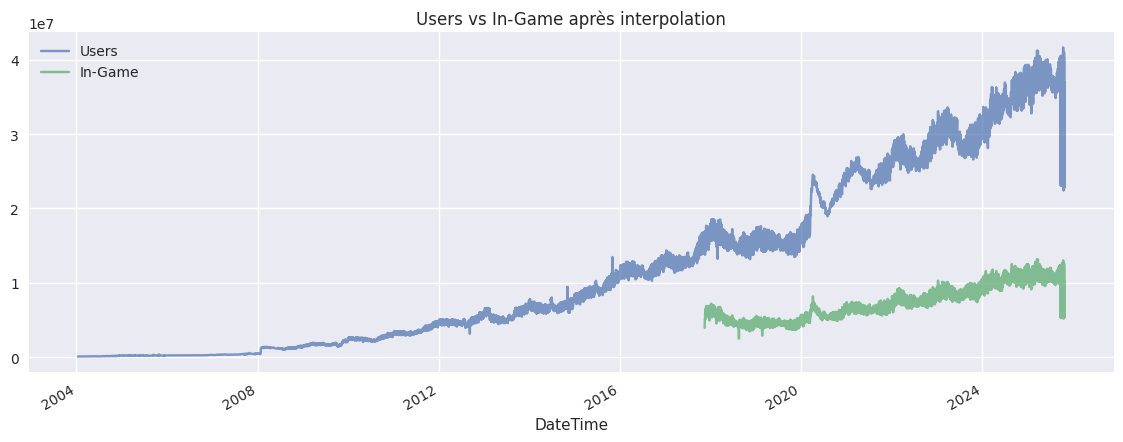

ADF Users p-value: 0.5554440676774888


In [ ]:
# Interpolation temporelle

df_weekly['Users'] = df_weekly['Users'].interpolate(method='time')
df_weekly['In-Game'] = df_weekly['In-Game'].interpolate(method='time')

# Plot pour vérifier visuellement l'interpolation
df_weekly[['Users', 'In-Game']].plot(figsize=(14,5), alpha=0.7)
plt.title("Users vs In-Game après interpolation")
plt.show()

# interpoler
df_weekly['Users'] = df_weekly['Users'].interpolate(method='time')
df_weekly['In-Game'] = df_weekly['In-Game'].interpolate(method='time')


result = adfuller(df_weekly['Users'])
print("ADF Users p-value:", result[1])





In [ ]:
# transformation pour stabiliser la variance
df_weekly['Users_log'] = np.log(df_weekly['Users'])
df_weekly['Users_log_diff'] = df_weekly['Users_log'].diff()

ADF = adfuller(df_weekly['Users_log_diff'].dropna())
print("ADF Users_log_diff p-value:", ADF[1])

# On est bon après la transformation


ADF Users_log_diff p-value: 7.328137774932345e-30


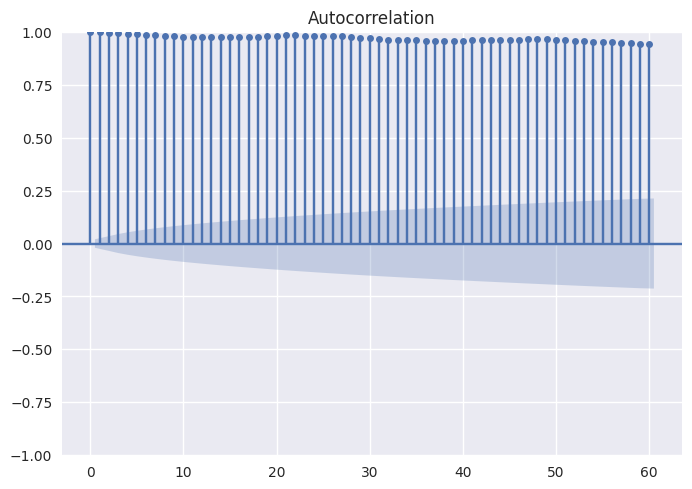

In [24]:

plot_acf(df_weekly['Users'], lags=60)
plt.show()


Autocorrelation très élevée à tous les lags, on observe des valeurs d'ACF très proches de 1 jusqu'au lag 60 ce qui signifie que chaque valeur dépends très fortement de ses valeurs passées, même lointaines. la série à une forte tendance et n'est pas stationnaire.

On ne voit pas de pic tous les 7 lag donc cela indique que la saisonnalité est noyée dans la tendence massive. la croissance globale domine tout.

Modèle	Conséquence si non-stationnaire
Prophet	risque de sur-ajustement + mauvaise généralisation (ce que tu as observé !)
LSTM / RNN	le modèle n'apprend que la tendance, pas la structure temporelle
ARIMA / GARCH	impossible à estimer correctement

Choix	Transformation	Utilisation recommandée
A	log + diff	Prophet optimisé
B	seasonal diff (lag=7)	Présentation académique
C	log + seasonal diff + diff	LSTM / RNN / Transformer (meilleure performance ML)

<Figure size 1200x400 with 0 Axes>

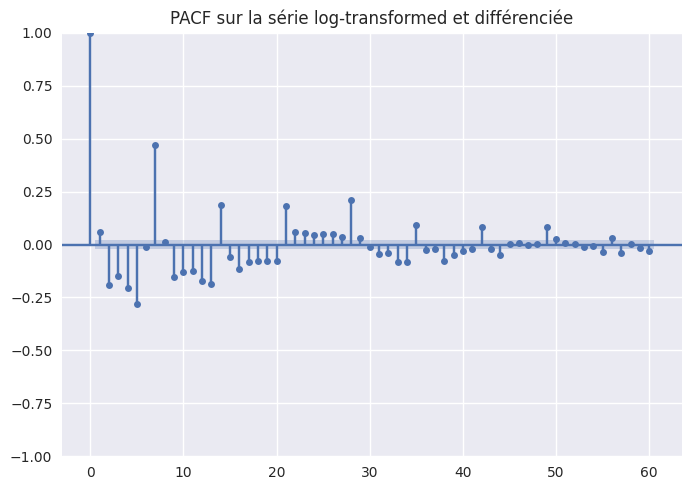

In [33]:
plt.figure(figsize=(12,4))
plot_pacf(df_weekly['Users_log_diff'].dropna(), lags=60, method='ywm')
plt.title("PACF sur la série log-transformed et différenciée")
plt.show()

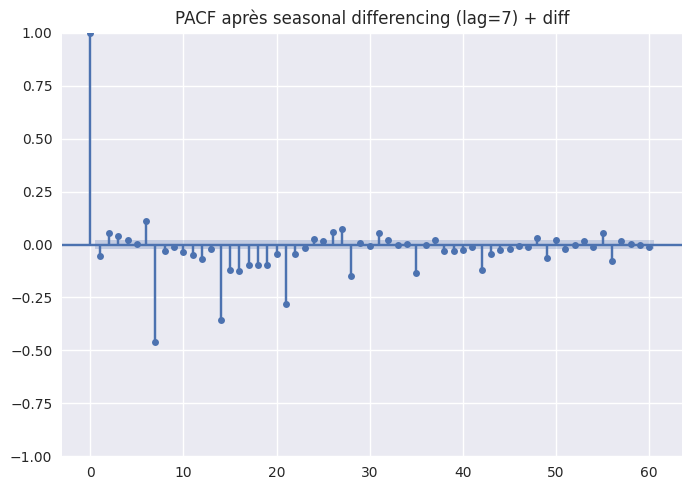

In [34]:
df_weekly['Users_log_diff7'] = df_weekly['Users_log'] - df_weekly['Users_log'].shift(7)
df_weekly['Users_log_diff7'] = df_weekly['Users_log_diff7'].diff()

plot_pacf(df_weekly['Users_log_diff7'].dropna(), lags=60, method='ywm')
plt.title("PACF après seasonal differencing (lag=7) + diff")
plt.show()


L’analyse de la fonction d’autocorrélation partielle (PACF) montre un pic marqué au lag 1 ainsi qu’un second pic au lag 7, indiquant que la dynamique de la série est principalement décrite par un processus autoregressif d’ordre 1, combiné à une saisonnalité hebdomadaire stable. Après application d’une différenciation saisonnière (lag=7) suivie d’une différenciation première, ces composantes disparaissent, ce qui confirme que la structure résiduelle de la série est stationnaire et dominée par une dépendance de premier ordre. Cette transformation est appropriée pour les modèles neuronaux (LSTM/RNN) ainsi que pour des modèles additifs structurés (Prophet avec régresseur externe).

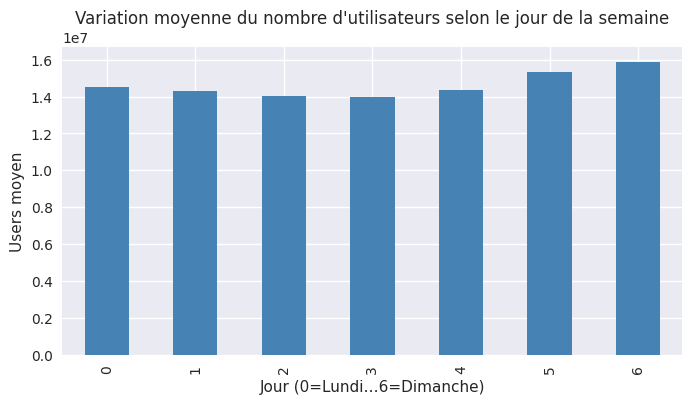

In [ ]:
# Variation des users au cours de la semaine

df_weekly['weekday'] = df_weekly.index.weekday  # 0 = Lundi, 6 = Dimanche

plt.figure(figsize=(8,4))
df_weekly.groupby('weekday')['Users'].mean().plot(kind='bar', color='steelblue')
plt.title("Variation moyenne du nombre d'utilisateurs selon le jour de la semaine")
plt.xlabel("Jour (0=Lundi…6=Dimanche)")
plt.ylabel("Users moyen")
plt.show()


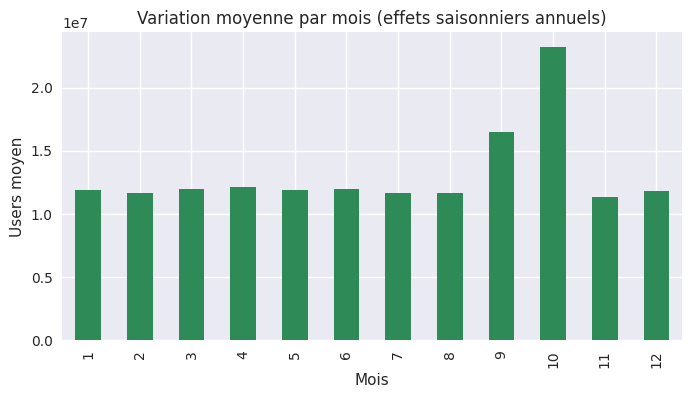

In [ ]:
# Variation des users par mois
df_weekly['month'] = df_weekly.index.month

plt.figure(figsize=(8,4))
df_weekly.groupby('month')['Users'].mean().plot(kind='bar', color='seagreen')
plt.title("Variation moyenne par mois (effets saisonniers annuels)")
plt.xlabel("Mois")
plt.ylabel("Users moyen")
plt.show()


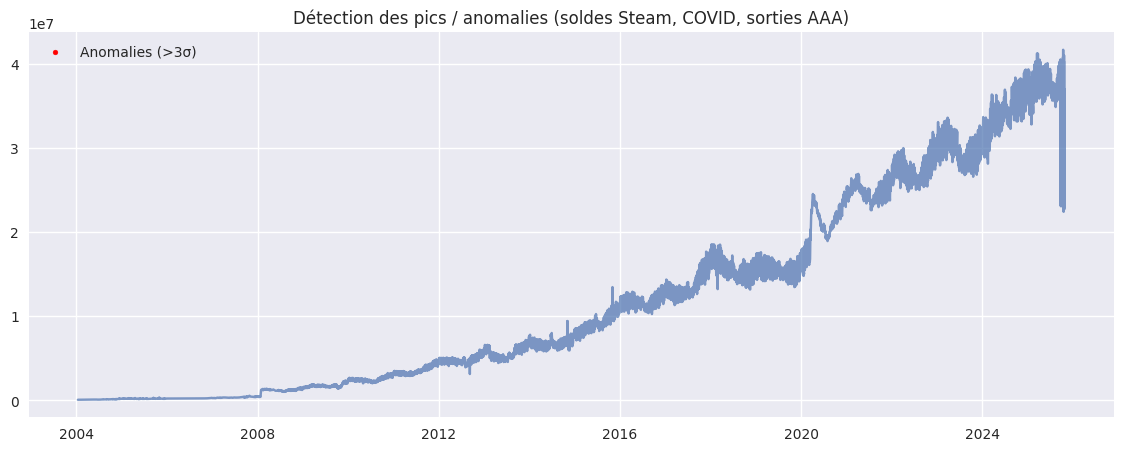

In [ ]:
# Detection des anomalies  

from scipy.stats import zscore

df_weekly['zscore'] = zscore(df_weekly['Users'])
anomalies = df_weekly[df_weekly['zscore'] > 3]  # seuil standard

plt.figure(figsize=(14,5))
plt.plot(df_weekly['Users'], alpha=0.7)
plt.scatter(anomalies.index, anomalies['Users'], color='red', s=12, label='Anomalies (>3σ)')
plt.legend()
plt.title("Détection des pics / anomalies (soldes Steam, COVID, sorties AAA)")
plt.show()

# a priori pas d'anomalies  

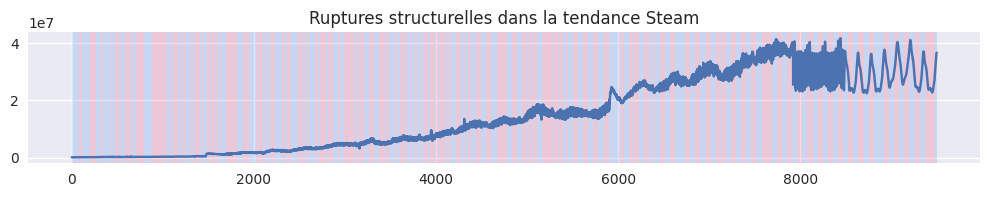

In [ ]:
#Ruptues de tendances ou changepoints
signal = df_weekly['Users'].values
model = "l2"
algo = rpt.Pelt(model=model).fit(signal)
breaks = algo.predict(pen=1e9)  

rpt.display(signal, breaks)
plt.title("Ruptures structurelles dans la tendance Steam")
plt.show()
